In [1]:
#Imports para descarga y procesamiento de datos
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Imports modelos y metricas de sklearn 
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
#Imports modelos y metricas de statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("companies.csv")[["Symbol", "Security"]]
###
# No se encontraron datos para los tickers BRK.B y BF.B y por ende se rmeovieron
#['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
#['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
###
df.loc[df["Symbol"] == "BRK.B", "Symbol"] = np.nan
df.loc[df["Symbol"] == "BF.B", "Symbol"] = np.nan
df = df.dropna()
tickers=df["Symbol"].to_list()

# Descarga y preparación de datos

In [2]:
#Se descargan los datos de cada ticker del S&P500 y se guardan en un dataframe con multi-indice llamado time_series
#además se descargan también los datos directamente de S&P500. Se usan los datos desde principios del 2015 hasta finales de octubre del 2025
START_DATE = "2015-01-01"
END_DATE = "2025-11-01"

time_series = yf.download(tickers, start=START_DATE, end=END_DATE, interval="1d", group_by='Ticker',auto_adjust=True)
s_and_p = yf.download("^GSPC", start=START_DATE, end=END_DATE, interval="1d", group_by="Ticker", auto_adjust=True)

[*********************100%***********************]  501 of 501 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
#Se log-transforman los datos del S&P para estacionar la serie y hacer más simple su manejo
s_and_p = np.log(s_and_p["^GSPC"]["Close"]) - np.log(s_and_p["^GSPC"]["Close"]).shift(1)

#Se usa el close de cada serie de tiempo para generar features nuevas que usar para entrenar el modelo, se usan lags del 1 al 3 log-transformados
#se log-transforma el volumen y se calcula el porcentaje de esparcimiento del high-low
for ticker in tickers:
    time_series[ticker, "Log-Returns"] = np.log(time_series[ticker]["Close"]) - np.log(time_series[ticker]["Close"].shift(1))
    time_series[ticker, "Log-Returns_t-1"] = time_series[ticker]["Log-Returns"].shift(1)
    time_series[ticker, "Log-Returns_t-2"] = time_series[ticker]["Log-Returns"].shift(2)
    time_series[ticker, "Log-Returns_t-3"] = time_series[ticker]["Log-Returns"].shift(3)
    time_series[ticker, "Volume-Change"] = np.log(time_series[ticker]["Volume"]) - np.log(time_series[ticker]["Volume"]).shift(1)
    time_series[ticker, "High-Low-Spread"] = (time_series[ticker]["High"] - time_series[ticker]["Low"]) / time_series[ticker]["Close"]

#Se ordenan las series de tiempo tras añadir las nuevas columnas
time_series = time_series.sort_index(axis=1)

In [4]:
#Se eliminan los tickers cuyas columnas tengan más de un 25% de valores nan
features = ["Log-Returns_t-1","Log-Returns_t-2","Log-Returns_t-3","Volume-Change", "High-Low-Spread"]
nan_percentage = time_series.isna().sum() / len(time_series)
worth_columns = nan_percentage[nan_percentage < 0.25].index

#Se limpia entonces X de nan y valores infinitos (-inf o inf) resultantes de tomar logaritmos en valores muy pequeños
X = time_series[worth_columns]
X = X.loc[:, pd.IndexSlice[:, features]]
X = X.sort_index(axis=1)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = s_and_p.dropna()

#Se alinean los dataframes para que compartan las mismas fechas
y, X = y.align(X, join="inner")

In [5]:
#Rango de fechas resultantes tras el filtrado
print(X.head(1).index)
print(X.tail(1).index)

DatetimeIndex(['2017-05-18'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2025-10-31'], dtype='datetime64[ns]', name='Date', freq=None)


In [6]:
#Se calcula el nivel de estacionareidad de la serie del S&P500, información útil al momento de implementar modelos del tipo ARIMA
estacionareidad = adfuller(y)
print("ADF Statistic:", estacionareidad[0])
print("p-value:", estacionareidad[1])

ADF Statistic: -14.619782436774457
p-value: 3.90164122446427e-27


# Modelo lineal (Ridge)

In [7]:
#Se realiza Expanding Window para hallar el mejor alpha para Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
alphas = np.logspace(-3, 3, 10)
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'alpha': alphas}
ridge = Ridge()

grid = GridSearchCV(
    ridge, 
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
print(f"Mejor alpha: {best_alpha}")

Mejor alpha: 1000.0


In [8]:
#Se entrena Ridge con el mejor alpha
model = Ridge(alpha=best_alpha)
model = model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

#Se visualiza MSE, R^2 y MAE en el conjunto de entrenamiento y testeo
print(f"TRAIN - MSE: {mean_squared_error(y_train, y_pred_train):.6f}, "
      f"R²: {r2_score(y_train, y_pred_train):.4f}, MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"TEST  - MSE: {mean_squared_error(y_test, y_pred):.6f}, "
      f"R²: {r2_score(y_test, y_pred):.4f}, MAE: {mean_absolute_error(y_test, y_pred)}")


TRAIN - MSE: 0.000149, R²: 0.1142, MAE: 0.00782008893894574
TEST  - MSE: 0.000091, R²: 0.0012, MAE: 0.006456657739364911


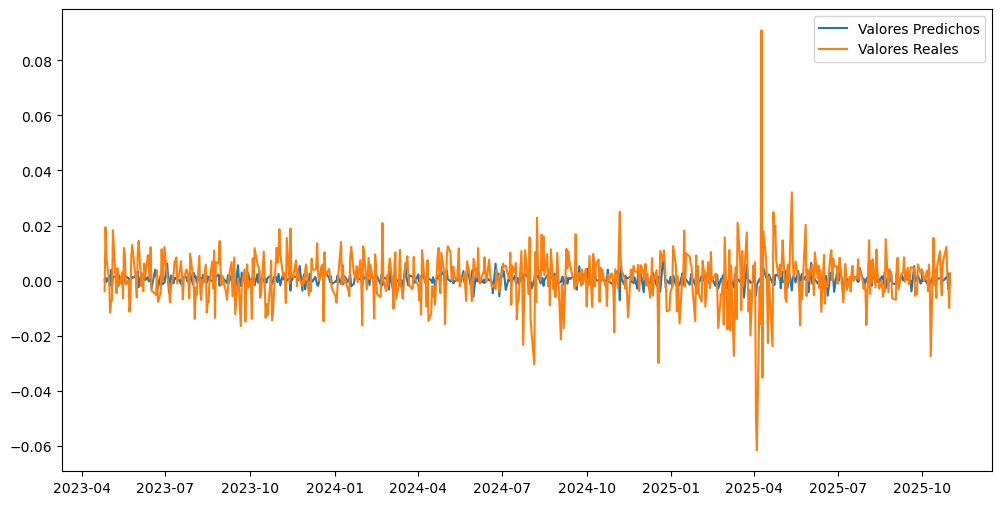

In [9]:
#Grafica para comparar visualmente el resultado de la predición de Ridge contra los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_pred, label="Valores Predichos")
plt.plot(y_test.index, y_test, label="Valores Reales")
plt.legend()

Text(0.5, 1.0, 'Error (y_test - y_pred) a lo largo del tiempo')

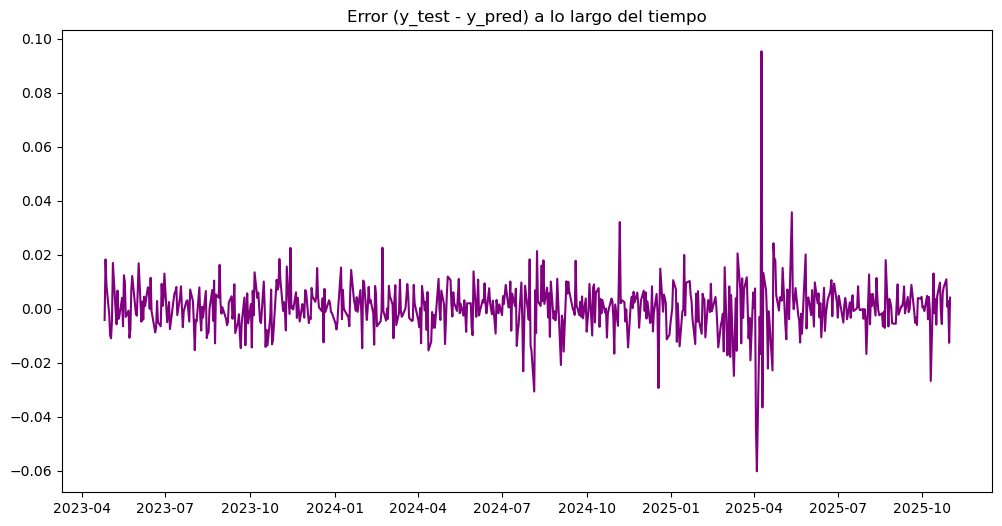

In [10]:
#Se visualiza la diferencia entre el valor real de testeo y la predicción
plt.figure(figsize=(12, 6))
plt.plot(y_test - y_pred, color="purple")
plt.title("Error (y_test - y_pred) a lo largo del tiempo")

Text(0.5, 1.0, 'Distribución de errores')

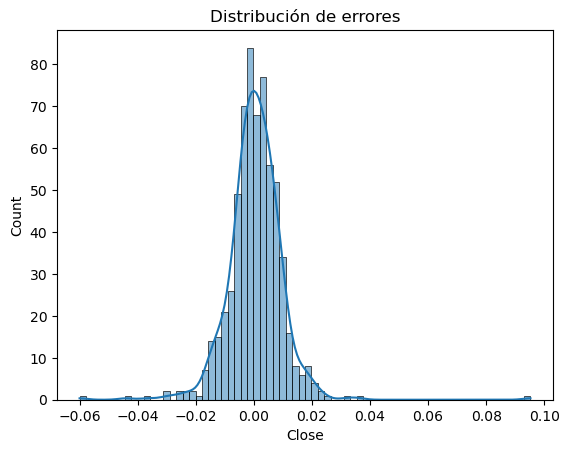

In [11]:
import seaborn as sns
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribución de errores")

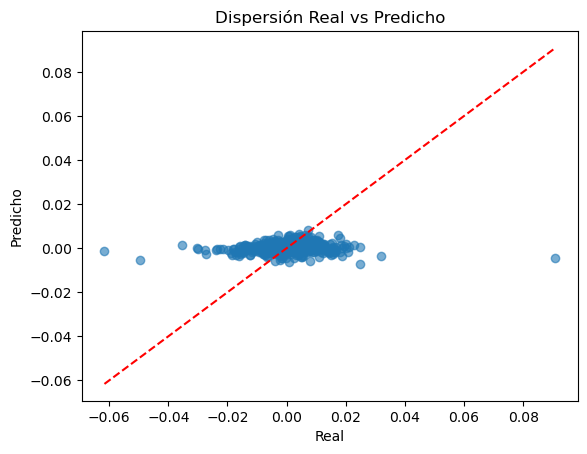

In [12]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Dispersión Real vs Predicho")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

# Modelo ARIMA

In [13]:
#Ahora entrenamos un modelo ARIMA donde se usan 5 términos autoregresivos, se aplica 0 diferenciación puesto que los resultados
#del test de estacionareidad fueron buenos y sin medias moviles, i.e, (5,0,0)
model_arima = ARIMA(y_train, order=(5,0,0))
fit_arima = model_arima.fit()
y_pred_arima = fit_arima.forecast(steps=len(y_test))

In [14]:
#Vemos como se desempeño el modelo en las metricas MSE, MAE y R^2
print(f"ARIMA - MSE: {mean_squared_error(y_test, y_pred_arima):.6f}, "
      f"R²: {r2_score(y_test, y_pred_arima):.4f}, MAE: {mean_absolute_error(y_test, y_pred_arima)}")

ARIMA - MSE: 0.000091, R²: -0.0037, MAE: 0.00644683993217529


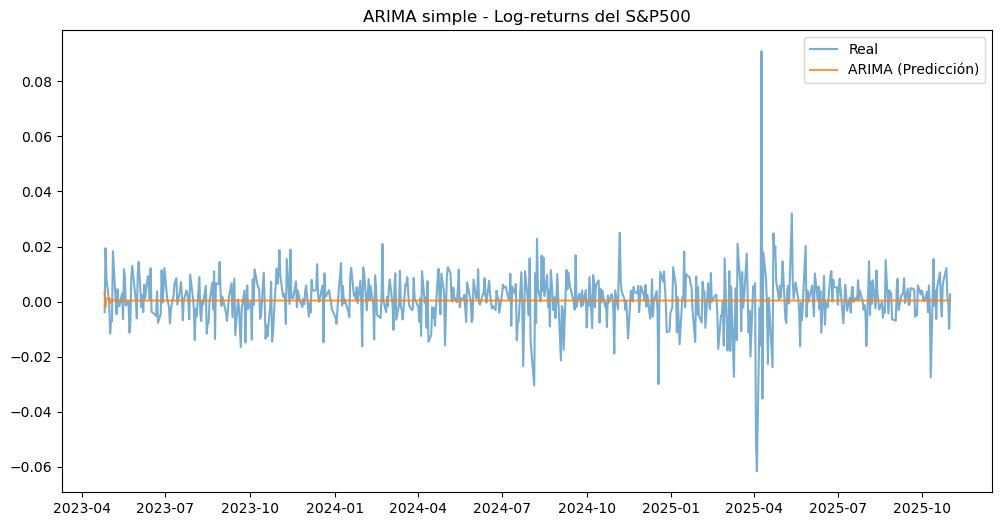

In [15]:
# Visualizamos los resultados
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Real", alpha=0.6)
plt.plot(y_test.index, y_pred_arima, label='ARIMA (Predicción)', alpha=0.8)
plt.title("ARIMA simple - Log-returns del S&P500")
plt.legend()
plt.show()

In [16]:
#Como los modelos ARIMA están pensados para irse actualizando y moviendo a medida que van prediciendo, o al menos no se espera
#que predigan mucho tiempo en el futuro sin actualizar, se hara el mismo testeo pero actualizando al modelo

new_data = list(y_train)
preds = []

for t in range(len(y_test)):
    # Entrena ARIMA hasta t
    model_arima_rolled = ARIMA(new_data, order=(3,0,1))  
    model_fit_rolled = model_arima_rolled.fit()
    
    y_new = model_fit_rolled.forecast()[0]
    preds.append(y_new)
    
    # agrega el valor real para el siguiente ciclo
    new_data.append(y_test.iloc[t])

In [17]:
print(f"ARIMA actualizandose - MSE: {mean_squared_error(y_test, preds):.6f}, "
      f"R²: {r2_score(y_test, preds):.4f}, MAE: {mean_absolute_error(y_test, preds)}")

ARIMA actualizandose - MSE: 0.000092, R²: -0.0145, MAE: 0.0065289993455282


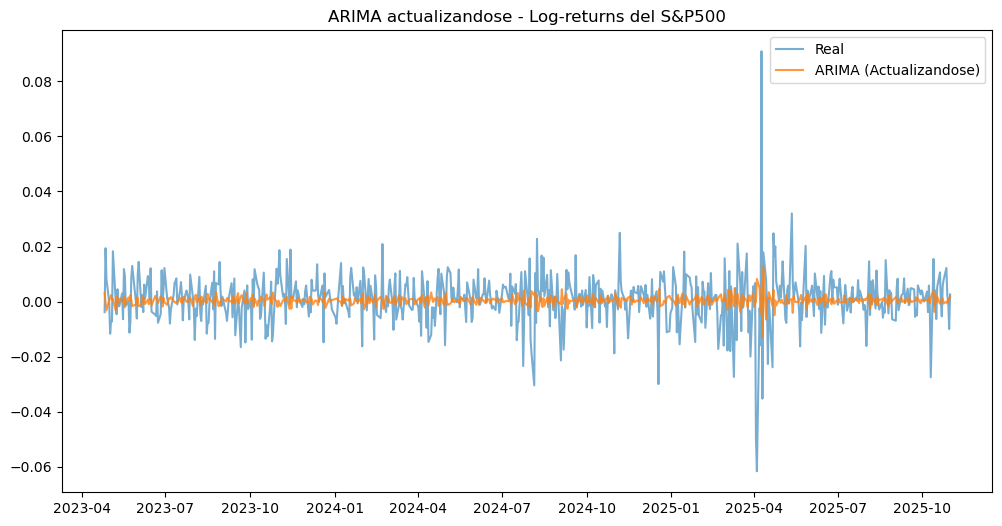

In [18]:
# Visualizamos los resultados
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Real", alpha=0.6)
plt.plot(y_test.index, preds, label='ARIMA (Actualizandose)', alpha=0.8)
plt.title("ARIMA actualizandose - Log-returns del S&P500")
plt.legend()
plt.show()

# Modelo SARIMAX (PCA)

In [36]:
#Se hace SARIMAX usando PCA para reducir el número de features a 10
n_componentes = 10
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, index=X.index, columns=[f'PC{i+1}' for i in range(n_componentes)])
explained = pca.explained_variance_ratio_
print(f"Varianza total explicada por los {n_componentes} componentes: {explained.sum():.2%}")

Varianza total explicada por los 10 componentes: 32.81%


In [37]:
#Se generan los conjuntos de train y test
X_SARIMAXpca_train, X_SARIMAXpca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

In [38]:
#Se entrena el modelo usando las variables producidas por PCA
model_sarimax_pca = SARIMAX(y_train, exog=X_SARIMAXpca_train, order=(2,0,2), enforce_stationarity=False, enforce_invertibility=False)
fit_sarimax_pca = model_sarimax_pca.fit()
y_pred_sarimax_pca = fit_sarimax_pca.predict(start=len(y_train), end=len(y)-1,exog=X_SARIMAXpca_test)

In [39]:
print(f"SARIMAX (PCA) - MSE: {mean_squared_error(y_test, y_pred_sarimax_pca):.6f}, "
      f"R²: {r2_score(y_test, y_pred_sarimax_pca):.4f}, MAE: {mean_absolute_error(y_test, y_pred_sarimax_pca)}")

SARIMAX (PCA) - MSE: 0.000092, R²: -0.0174, MAE: 0.006470704932721328


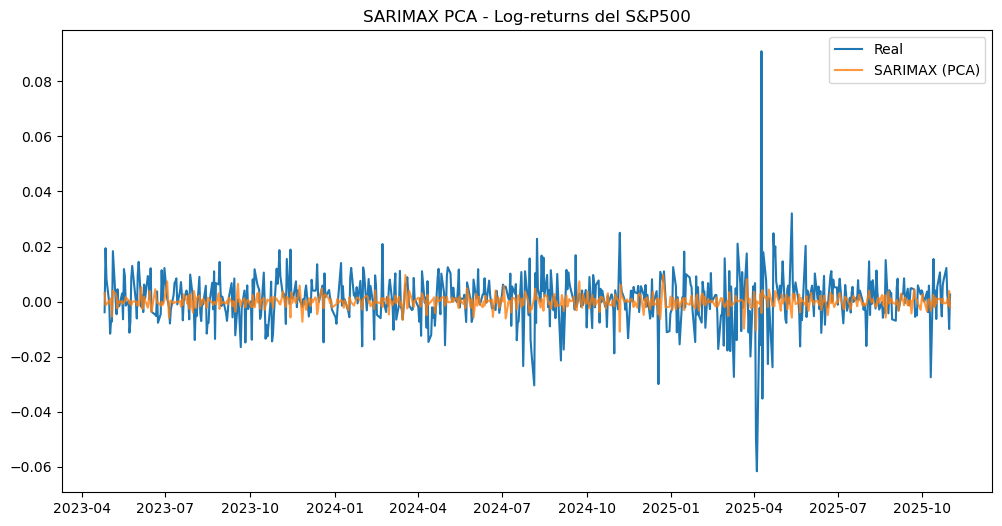

In [40]:
# Visualizamos los resultados
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_sarimax_pca, label='SARIMAX (PCA)', alpha=0.8)
plt.title("SARIMAX PCA - Log-returns del S&P500")
plt.legend()
plt.show()

In [41]:
#Similarmente haremos un rolling forecasting para poder predecir con mayor exactitud los retornos y ver si podemos atrapar más varianza del problema
new_data_pca = list(y_train)
preds_pca = []

for t in range(len(y_test)):
    # Entrena SARIMA PCA hasta t
    model_arima_pca_rolled = ARIMA(new_data_pca, order=(3,0,1))  
    model_fit_pca_rolled = model_arima_pca_rolled.fit()
    
    y_new_pca = model_fit_pca_rolled.forecast()[0]
    preds_pca.append(y_new)
    
    # agrega el valor real para el siguiente ciclo
    new_data_pca.append(y_test.iloc[t])

In [42]:
print(f"SARIMAX (PCA) Rolling - MSE: {mean_squared_error(y_test, preds_pca):.6f}, "
      f"R²: {r2_score(y_test, preds_pca):.4f}, MAE: {mean_absolute_error(y_test, preds_pca)}")

SARIMAX (PCA) Rolling - MSE: 0.000092, R²: -0.0124, MAE: 0.006472484619759626


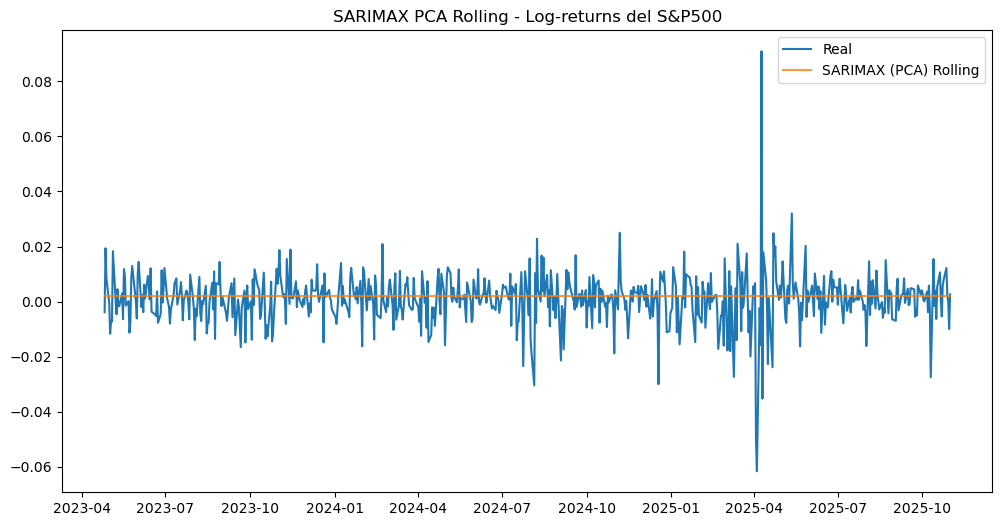

In [43]:
# Visualizamos los resultados
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, preds_pca, label='SARIMAX (PCA) Rolling', alpha=0.8)
plt.title("SARIMAX PCA Rolling - Log-returns del S&P500")
plt.legend()
plt.show()

### Modelo SARIMAX (Con todas las features)

In [44]:
#Se generan los conjuntos de train y test para SARIMAX nuevamente, pero esta vez se usan todas las features
X_SARIMAX_train, X_SARIMAX_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [45]:
#Se entrena el modelo usando todas las features
model_sarimax = SARIMAX(y_train, exog=X_SARIMAX_train, order=(2,0,2), enforce_stationarity=False, enforce_invertibility=False)
fit_sarimax = model_sarimax.fit()
y_pred_sarimax = fit_sarimax.predict(start=len(y_train), end=len(y)-1,exog=X_SARIMAX_test)

In [46]:
print(f"SARIMAX All features - MSE: {mean_squared_error(y_test, y_pred_sarimax):.6f}, "
      f"R²: {r2_score(y_test, y_pred_sarimax):.4f}, MAE: {mean_absolute_error(y_test, y_pred_sarimax)}")


SARIMAX All features - MSE: 0.000442, R²: -3.8667, MAE: 0.016557139864262434


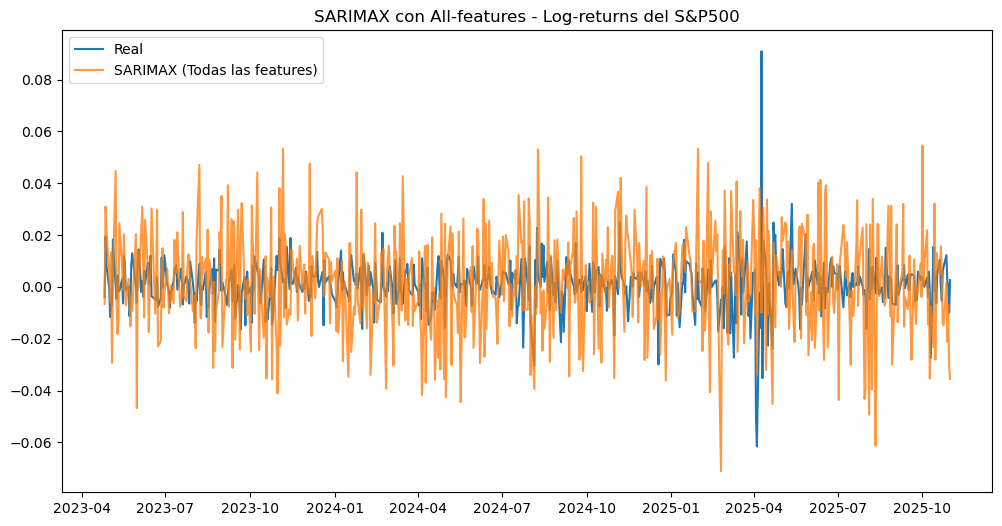

In [47]:
# Visualizamos los resultados
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_sarimax, label='SARIMAX (Todas las features)', alpha=0.8)
plt.title("SARIMAX con All-features - Log-returns del S&P500")
plt.legend()
plt.show()

### Modelo Random Forest Regressor 

In [48]:
#Se entrena un modelo de Random Forest Regressor para comparar
rfr_model = RandomForestRegressor(
    n_estimators=300,      
    max_depth=8,           
    random_state=42,
    n_jobs=-1,             
    oob_score=True, # <--- Validacion interna (creo)      
)
rfr_model = rfr_model.fit(X_train, y_train)

y_pred_rfr = rfr_model.predict(X_test)

In [49]:
print(f"Random Forest Regressor - MSE: {mean_squared_error(y_test, y_pred_rfr):.6f}, "
      f"R²: {r2_score(y_test, y_pred_rfr):.4f}, MAE: {mean_absolute_error(y_test, y_pred_rfr)}")

Random Forest Regressor - MSE: 0.000090, R²: 0.0114, MAE: 0.006229671194917177


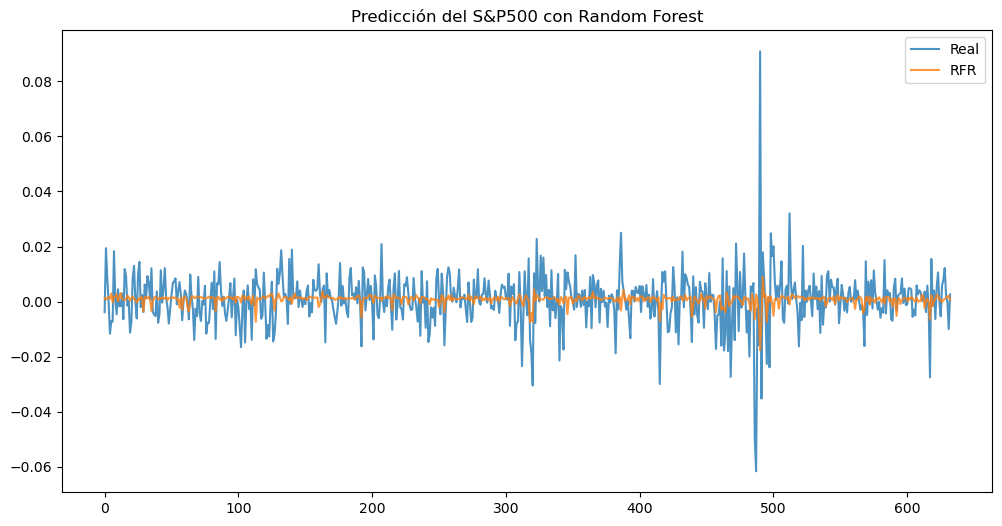

In [50]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Real', alpha=0.8)
plt.plot(y_pred_rfr, label='RFR', alpha=0.8)
plt.legend()
plt.title("Predicción del S&P500 con Random Forest")
plt.show()


# Analisis de features y stocks

In [51]:
#Extraemos los coeficientes de los modelos de Ridge, SARIMAX con todas las features y Random Forest Regression
#ya que son los únicos que conservan información sobre los stocks
ridge_coefs = pd.Series(model.coef_, index=X_train.columns).astype(float)
sarimax_coefs = fit_sarimax.params
rfr_coefs = pd.Series(rfr_model.feature_importances_, index=X_train.columns).astype(float)

In [52]:
#Vamos a extraer el top 20 de stocks por cada modelo al sumar el peso que tiene cada una de sus features
top_rfr = set(rfr_coefs.groupby(level=0).sum().sort_values(ascending=False).head(20).index)
top_ridge = set(ridge_coefs.groupby(level=0).sum().sort_values(ascending=False).head(20).index)

#En el caso de SARIMAX las features se guardaron con la estructura {ticker}-{tipo_de_feature}, por lo que el proceso es diferente
sarimax_features = sarimax_coefs[sarimax_coefs.index.str.contains('_')].copy() #Usamos esto para excluir las variables propias de SARIMAX como ar.L1
tickers = sarimax_features.index.str.split('_').str[0]
sarimax_importance_by_ticker = sarimax_features.groupby(tickers).sum()
top_sarimax = set(sarimax_importance_by_ticker.sort_values(ascending=False).head(20).index)


In [53]:
#Se calculan las intersecciones de los mejores 20 stocks por modelo y feature
intersection_all = top_rfr & top_ridge & top_sarimax
intersection_pairwise = {
    "rfr_ridge": top_rfr & top_ridge,
    "rfr_sarimax": top_rfr & top_sarimax,
    "ridge_sarimax": top_ridge & top_sarimax
}

In [54]:
print("Mejores 20 stocks en RFR:", "\n", top_rfr, "\n")
print("Mejores 20 stocks en Ridge:", "\n", top_ridge, "\n")
print("Mejores 20 stocks en SARIMAX:", "\n", top_sarimax, "\n")
print("Intersección en los 3 modelos:", "\n", intersection_all, "\n")
print("Intersección de a dos modelos:", "\n", intersection_pairwise, "\n")


Mejores 20 stocks en RFR: 
 {'AMGN', 'EMN', 'PNC', 'AAPL', 'EG', 'PNW', 'MSFT', 'NCLH', 'RJF', 'MPC', 'WTW', 'CSCO', 'OXY', 'ACN', 'GM', 'PEP', 'APTV', 'APH', 'PSX', 'BLK'} 

Mejores 20 stocks en Ridge: 
 {'HST', 'HOLX', 'ACGL', 'TRGP', 'LLY', 'RMD', 'TRMB', 'PNR', 'WAB', 'MOS', 'STLD', 'DXCM', 'EXPE', 'LW', 'ELV', 'BIIB', 'BAX', 'NTAP', 'MNST', 'REG'} 

Mejores 20 stocks en SARIMAX: 
 {'INVH', 'ADSK', 'GPN', 'CHTR', 'BALL', 'SHW', 'CTAS', 'CRL', 'AZO', 'EBAY', 'BLK', 'FTV', 'LW', 'EW', 'INCY', 'CF', 'JBHT', 'JPM', 'CFG', 'REG'} 

Intersección en los 3 modelos: 
 set() 

Intersección de a dos modelos: 
 {'rfr_ridge': set(), 'rfr_sarimax': {'BLK'}, 'ridge_sarimax': {'LW', 'REG'}} 

